In [40]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import make_country_mask
import xarray as xr
import numpy as np
import clustering_sklearn as cl
import utils
import plotting
path_obs_data = '~/data/volume_2/observational/'
filename = 'chrips_tp_1981-2021_africa_aggregated_intervals.nc'
path_tp = os.path.join(path_obs_data, 'preprocessed', filename)

In [41]:
# ds_EC46 = xr.open_dataset('/data/volume_2/subseasonal/ecmwf/hindcast/ecmwf-hindcast-tp-20010618.nc')
# ds_EC46 = ds_EC46.isel(realization=0, lead_time=0, forecast_time=0)
# ds_EC46 = utils.formatting_ds(ds_EC46, format_lon='west_east')
# ds_EC46 = utils.get_selbox(ds_EC46, selbox=(10, 60, -30, 30))
# mask_xr, df_names = make_country_mask.create_mask(tp, level='Countries')
# hoa_countries = ['Kenya', 'Ethiopia', 'Uganda', 'Somalia']
# df_hoa = df_names[(df_names['abbrev']=='KE') | (df_names['abbrev']=='ET') | \
#                   (df_names['abbrev']=='UG') | (df_names['abbrev']=='SO')]
# df_hoa
# # create a Horn of Africa (hoa) mask
# hoa_mask = utils.view_or_replace_labels(mask_xr, regions=df_hoa['label'].values.astype(int))
# hoa_mask.plot()

Open dataset, align format, select OND months 

In [42]:
tp = xr.open_dataarray(path_tp)
# calender = time.AdventCalendar(anchor_date=(1,1), freq='1M')

# keep_months = [10,11,12]
# mask = [True if m in keep_months else False for m in tp.time.dt.month]
# tp = tp.where(np.array(mask)[:,None,None]).dropna(dim='time')

<xarray.DataArray 'precip' (anchor_year: 41, target_period: 10, latitude: 51,
                            longitude: 52)>
array([[[[3.406044, ...,      nan],
         ...,
         [0.652046, ...,      nan]],

        ...,

        [[4.634342, ...,      nan],
         ...,
         [0.232817, ...,      nan]]],


       ...,


       [[[0.238259, ...,      nan],
         ...,
         [3.709222, ...,      nan]],

        ...,

        [[3.605599, ...,      nan],
         ...,
         [0.435218, ...,      nan]]]], dtype=float32)
Coordinates:
  * anchor_year    (anchor_year) int64 1981 1982 1983 1984 ... 2019 2020 2021
  * target_period  (target_period) int64 0 1 2 3 4 5 6 7 8 9
  * longitude      (longitude) float64 38.12 38.38 38.62 ... 50.38 50.62 50.88
  * latitude       (latitude) float64 -4.625 -4.375 -4.125 ... 7.375 7.625 7.875
    target         bool True

In [43]:
path_tp

'~/data/volume_2/observational/preprocessed/chrips_tp_1981-2021_africa_aggregated_intervals.nc'

Calculate mean over OND months

In [45]:
tp_OND = tp.groupby(tp.anchor_year).mean(dim='target_period')

In [46]:
mask_xr, df_names = make_country_mask.create_mask(tp_OND[0], level='Countries')

hoa_countries = ['Kenya', 'Ethiopia', 'Uganda', 'Somalia']
df_hoa = df_names[(df_names['abbrev']=='KE') | (df_names['abbrev']=='ET') | \
                  (df_names['abbrev']=='UG') | (df_names['abbrev']=='SO')]
df_hoa

,abbrev,label,name
2,ET,69,Ethiopia
3,KE,115,Kenya
5,SO,206,Somalia
8,UG,231,Uganda


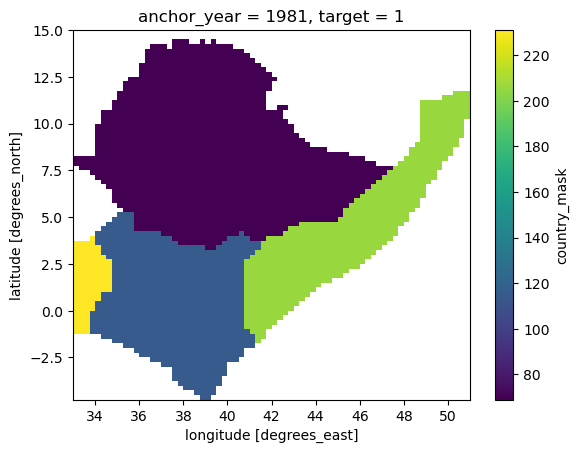

In [47]:
# create a Horn of Africa (hoa) mask
hoa_mask = utils.view_or_replace_labels(mask_xr, regions=df_hoa['label'].values.astype(int))
hoa_mask.plot()

Plotting Corr maps precip, split 0, lag 0
Plotting Corr maps precip, split 0, lag 0


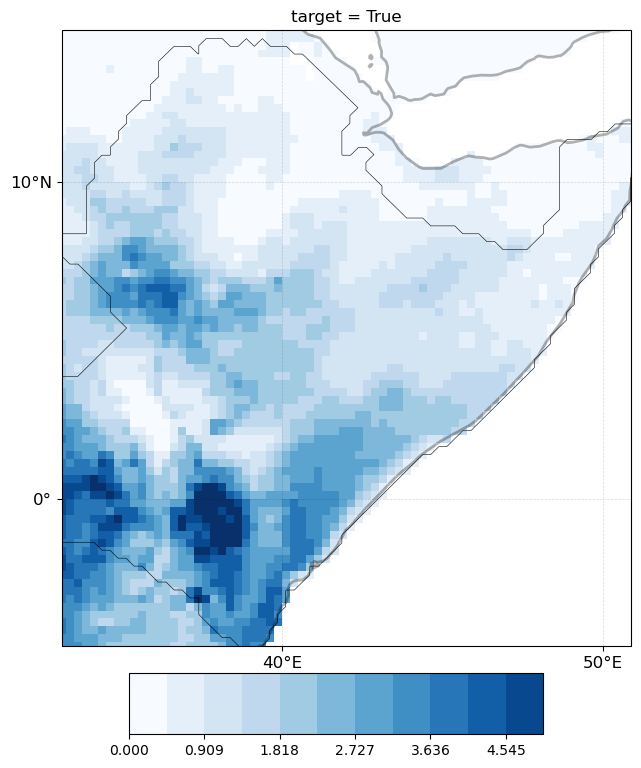

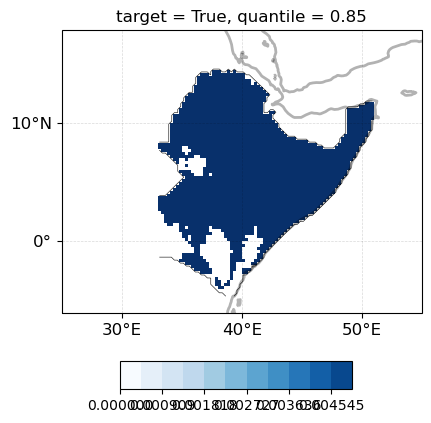

In [48]:
# climatoligical mean of OND rainfall
plotting.plot_maps(tp.mean(dim=('anchor_year', 'target_period')), mask_xr=~np.isnan(hoa_mask), 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5, 12))

# Keeping 85% of most dry gridcells in HoA
tp_hoa_OND = tp_OND.where(~np.isnan(hoa_mask).values)
mask_wet_regions = tp_hoa_OND.mean(dim=('anchor_year')) < tp_hoa_OND.quantile(.85)
tp_hoa_OND_dry = tp_OND.where(mask_wet_regions)
fg = plotting.plot_maps(tp_hoa_OND_dry.mean(dim=('anchor_year')), mask_xr=~np.isnan(hoa_mask), 
                       size=4, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12), zoomregion=(25,55,-6,18))

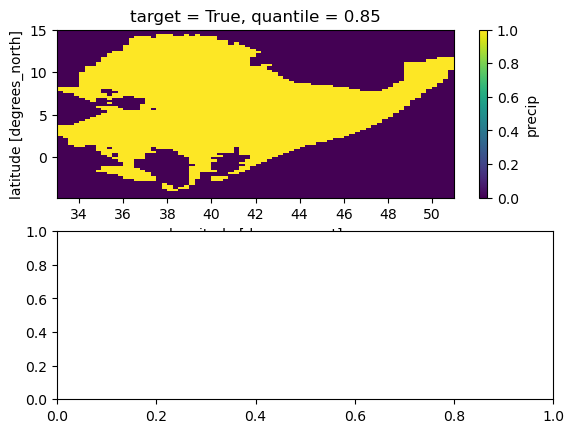

In [49]:
f, axs = plt.subplots(2)
mask_wet_regions.plot(ax=axs[0])
os.chdir('/data/volume_2/observational')
path_mask = 'chirps_hoa_dry_mask_0.25deg_new.nc'
if os.path.isfile(path_mask):
    os.remove(path_mask)
mask_wet_regions.to_netcdf(path_mask, mode='w')
# mask_EC46_res = utils.regrid_xarray(mask_wet_regions, 1.5, periodic=False) # regrid to 1.5 degrees
# mask_EC46_res.plot(ax=axs[1])
# mask_EC46_res.to_netcdf('/data/volume_2/subseasonal/chirps_hoa_dry_mask_1.5deg.nc')
# ds_EC46 = xr.open_dataset('/data/volume_2/subseasonal/ecmwf/forecast/ecmwf-forecast-tp-20200611.nc')['tp']
# ds_EC46lonlat = ds_EC46.isel(forecast_time=0).mean(dim=('realization', 'lead_time'))
# ds_EC46lonlat = utils.get_selbox(ds_EC46lonlat, selbox=(10, 70, -30, 25))
# fg = plotting.plot_maps(ds_EC46lonlat.where(mask_EC46_res.values), 
#                        size=4, cbar_vert=-0.1, cmap=plt.cm.Blues,  clevels=np.linspace(0, 5E-3, 12), zoomregion=(25,55,-6,18))

          target  Ethiopia  target     Kenya  target   Somalia  target  \
target       NaN       NaN     NaN       NaN     NaN       NaN     NaN   
Ethiopia     NaN  1.000000     NaN  0.875733     NaN  0.919317     NaN   
target       NaN       NaN     NaN       NaN     NaN       NaN     NaN   
Kenya        NaN  0.875733     NaN  1.000000     NaN  0.919650     NaN   
target       NaN       NaN     NaN       NaN     NaN       NaN     NaN   
Somalia      NaN  0.919317     NaN  0.919650     NaN  1.000000     NaN   
target       NaN       NaN     NaN       NaN     NaN       NaN     NaN   
Uganda       NaN  0.686955     NaN  0.777872     NaN  0.683544     NaN   

            Uganda  
target         NaN  
Ethiopia  0.686955  
target         NaN  
Kenya     0.777872  
target         NaN  
Somalia   0.683544  
target         NaN  
Uganda    1.000000  


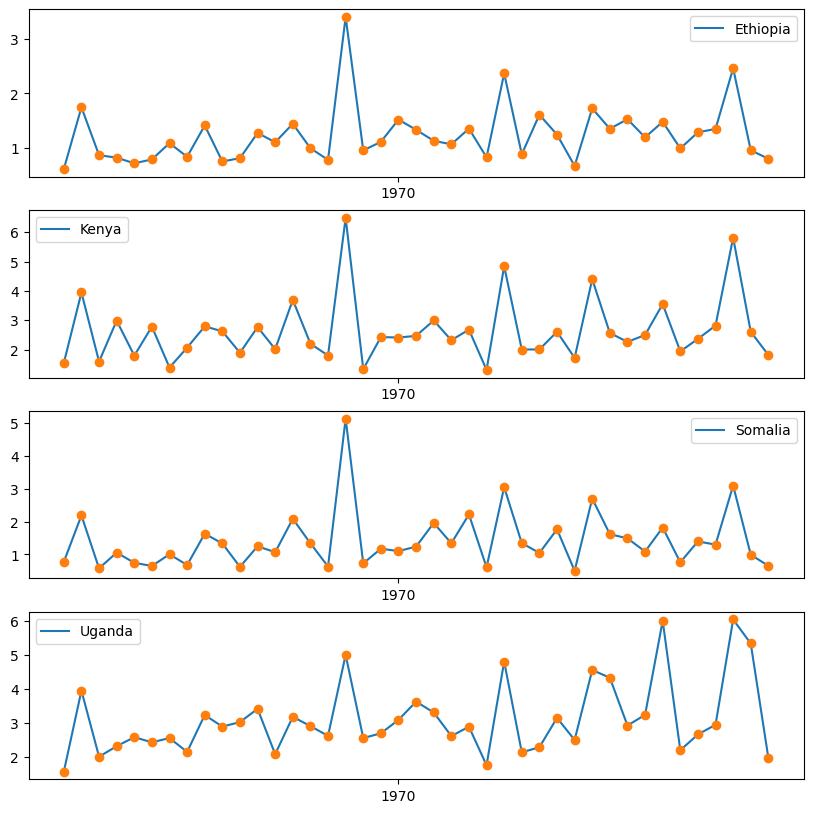

In [51]:
country_labels = np.unique(hoa_mask)[:-1].astype(int)
fig, axes = plt.subplots(len(country_labels), figsize=(10,10))
dfs = []
for i, label in enumerate(country_labels):
    tp_country = tp_hoa_OND.where(hoa_mask.values==label).mean(dim=('latitude', 'longitude'))
    country_name = df_hoa[df_hoa['label'].astype(int)==label]['name'].values[0]
    axes[i].plot(utils.pd.to_datetime(tp_country.anchor_year.values), tp_country.values, label=country_name)
    axes[i].plot_date(x=utils.pd.to_datetime(tp_country.anchor_year.values), y=tp_country, label=None)
    axes[i].legend()
    dfs.append(tp_country.to_dataframe(name=country_name))
print(pd.concat(dfs, axis=1).corr())

In [14]:
tp_hoa = tp_OND.where(~np.isnan(hoa_mask))

In [52]:
n_clusters = 3
xrclustered, algorithm = cl.skclustering(tp_hoa, spatial_mask=~np.isnan(hoa_mask), 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': n_clusters},
                                         dimension='spatial')

plotting.plot_labels(xrclustered,   
                     kwrgs_plot={'size':8, 'cbar_vert':-0.1, 'mask_xr':~np.isnan(hoa_mask)} )

NameError: name 'tp_hoa' is not defined

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


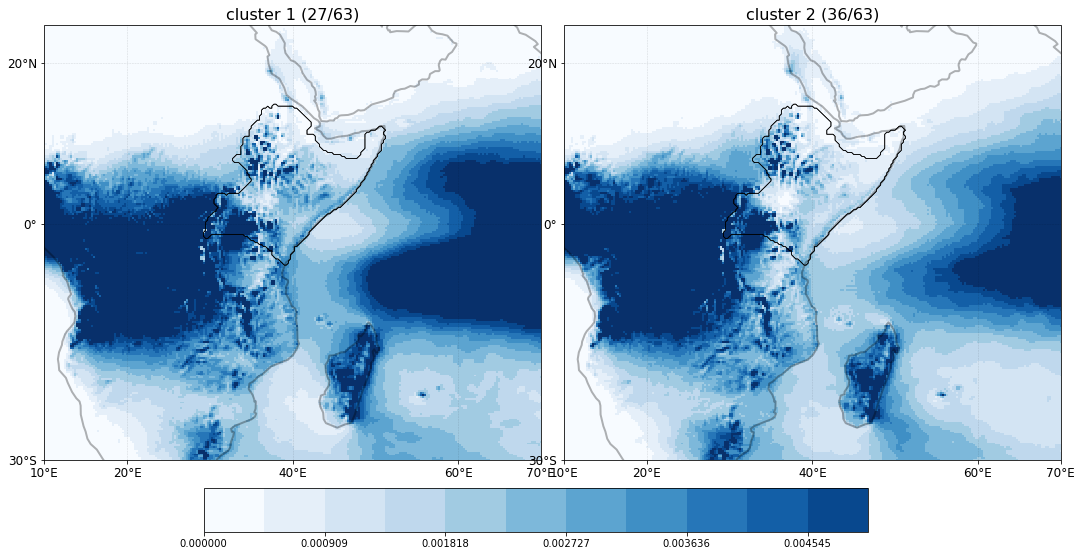

In [16]:
xrclustered, algorithm = cl.skclustering(tp_OND, spatial_mask=None, 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 2, 'affinity':'correlation', 'linkage':'complete'},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))

plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


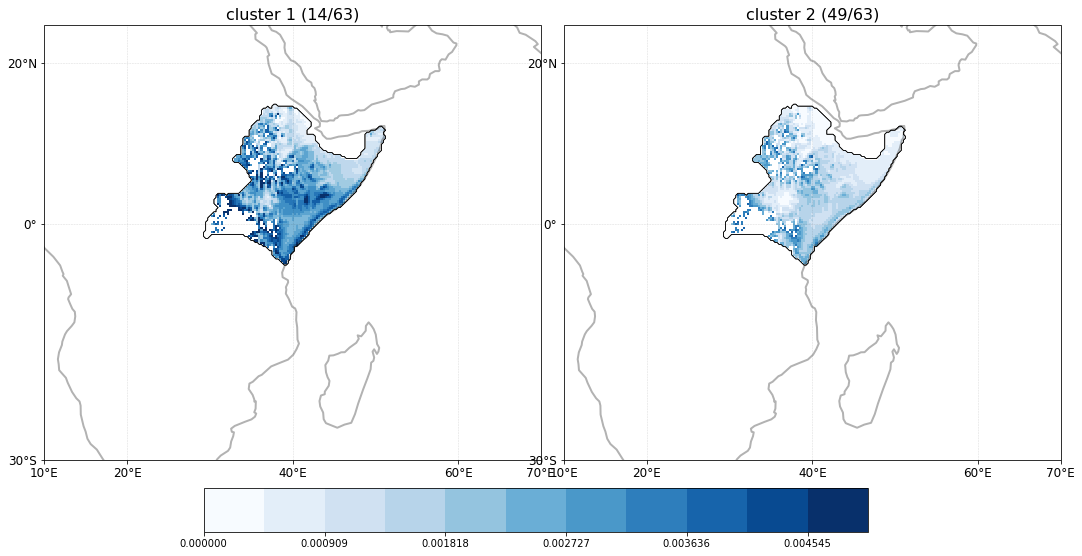

In [17]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(mask_wet_regions), spatial_mask=None, 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': 2},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


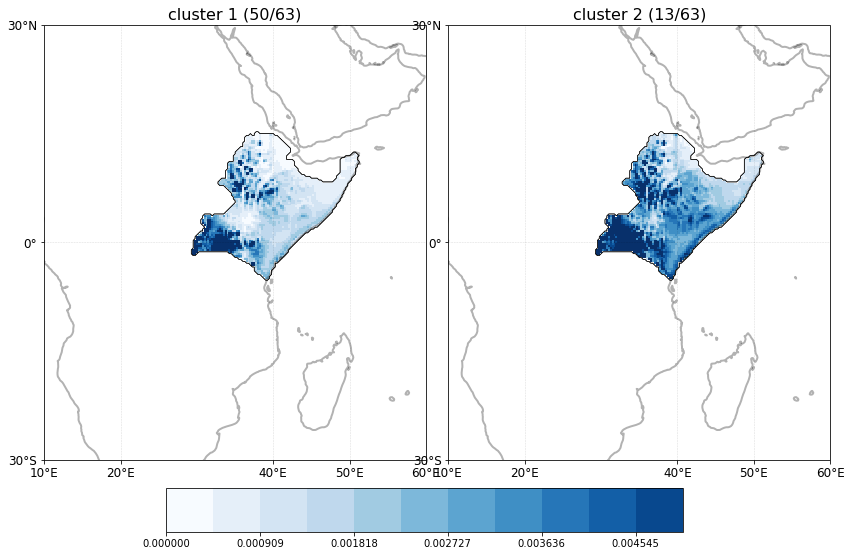

In [47]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(~np.isnan(hoa_mask).values), spatial_mask=None, 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': 2},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


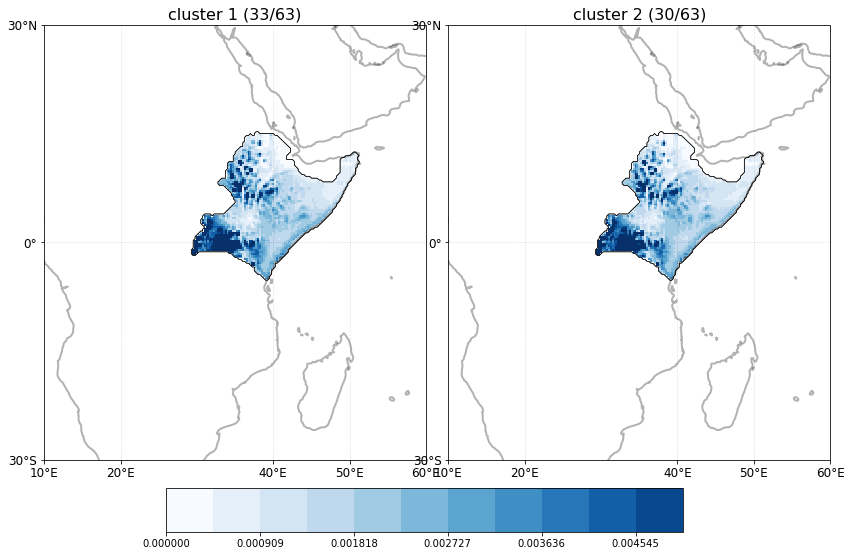

In [46]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(~np.isnan(hoa_mask).values), spatial_mask=None, 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 2, 'affinity':'correlation', 'linkage':'complete'},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, lag 0


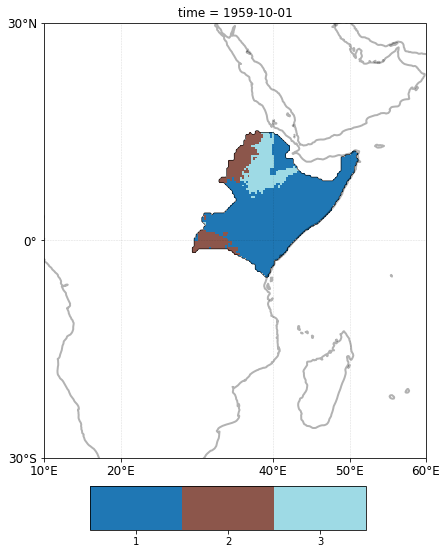

In [49]:
tp_hoa_binary = cl.binary_occurences_quantile(tp_hoa, 66)

xrclustered, algorithm = cl.skclustering(tp_hoa_binary, spatial_mask=~np.isnan(hoa_mask), 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 3, 'affinity':'jaccard', 'linkage':'complete'},
                                         dimension='spatial')
plotting.plot_labels(xrclustered,   
                   kwrgs_plot={'size':8, 'cbar_vert':-0.1, 'mask_xr':~np.isnan(hoa_mask)} )

In [70]:
df_hoa['label']

12     69
19    115
36    206
41    231
Name: label, dtype: object

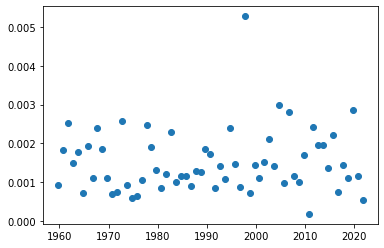

In [53]:
plt.plot_date(x=utils.pd.to_datetime(tp_somalia.time.values), y=tp_somalia)

In [54]:
df = tp_somalia.to_dataframe(name='tp_somalia')

<AxesSubplot:xlabel='time'>

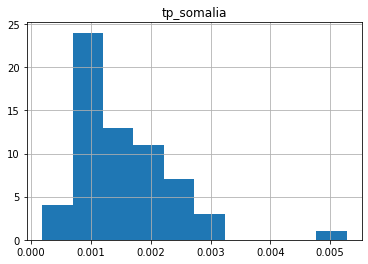

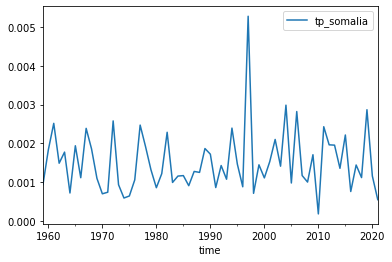

In [55]:
df.loc[df.index.month==10].hist() ; df.loc[df.index.month==10].plot()